# Transformers Benchmarks

This notebook evaluates BERT and GPT training performance on single and multiple GPUs. 

## Setup

First check environment and all available GPUs and install required packages. Note that both deepspeed and megatron-lm need `nvcc` to build custom operators. Make sure you have a complete CUDA installation rather than just runtime.

In [1]:
from IPython.display import clear_output
import torch

!pip install datasets evaluate accelerate deepspeed psutil pybind11

clear_output()

print('Pytorch version\t:', torch.__version__)
print('CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

Pytorch version	: 1.12.1+cu116
CUDA version	: 11.6
GPU0		: Tesla V100-SXM2-16GB
GPU1		: Tesla V100-SXM2-16GB
GPU2		: Tesla V100-SXM2-16GB
GPU3		: Tesla V100-SXM2-16GB
GPU4		: Tesla V100-SXM2-16GB
GPU5		: Tesla V100-SXM2-16GB
GPU6		: Tesla V100-SXM2-16GB
GPU7		: Tesla V100-SXM2-16GB


Next setup Megatron-LM and Huggingface transformers.

In [2]:
!git clone https://github.com/NVIDIA/Megatron-LM || true

clear_output()

Here we apply a patch to HuggingFace transformers. The reason is that although HF Trainer reports samples/second after training, its training time includes unnecessary overheads such as data loader. These overheads may mislead our analysis, because in this benchmark we only care the throughput of each training setp.

Accordingly, we patch HF Trainer to log step latencies, and use them to estimate samples/second. Since Megatron-LM adopts the same methodology, this gives us an apple-to-apple comparison.

In [33]:
!git clone https://github.com/huggingface/transformers || true
clear_output()

# Note that this patch is generated with transformers commit
# 801ebd045d4310fef2e837713fa630cb183f0104 @ Mon Sep 19 16:55:50 2022 -0400
with open("transformers/benchmark.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/trainer.py b/src/transformers/trainer.py
index c1869ef76..06d33d24b 100755
--- a/src/transformers/trainer.py
+++ b/src/transformers/trainer.py
@@ -1712,7 +1712,9 @@ class Trainer:
                 self._load_rng_state(resume_from_checkpoint)

             step = -1
+            step_metrics = {"step_time_list": []}
             for step, inputs in enumerate(epoch_iterator):
+                step_start = time.time()

                 # Skip past any already trained steps if resuming training
                 if steps_trained_in_current_epoch > 0:
@@ -1819,6 +1821,7 @@ class Trainer:
                 else:
                     self.control = self.callback_handler.on_substep_end(args, self.state, self.control)

+                step_metrics["step_time_list"].append(time.time() - step_start)
                 if self.control.should_epoch_stop or self.control.should_training_stop:
                     break
             if step < 0:
@@ -1865,6 +1868,7 @@ class Trainer:
         train_loss = self._total_loss_scalar / self.state.global_step

         metrics = speed_metrics("train", start_time, num_samples=num_train_samples, num_steps=self.state.max_steps)
+        metrics.update(step_metrics)
         self.store_flos()
         metrics["total_flos"] = self.state.total_flos
         metrics["train_loss"] = train_loss
diff --git a/src/transformers/trainer_pt_utils.py b/src/transformers/trainer_pt_utils.py
index 7ff0eb51a..ea5134e5a 100644
--- a/src/transformers/trainer_pt_utils.py
+++ b/src/transformers/trainer_pt_utils.py
@@ -867,6 +867,8 @@ def metrics_format(self, metrics: Dict[str, float]) -> Dict[str, float]:
             metrics_copy[k] = f"{ int(v) >> 30 }GF"
         elif type(metrics_copy[k]) == float:
             metrics_copy[k] = round(v, 4)
+        elif "_list" in k:
+            metrics_copy[k] = f"{','.join(str(round(e, 4)) for e in v)}"

     return metrics_copy

''')

!cd transformers; git reset origin/main --hard; git apply benchmark.patch; git status

# Install the changed transformers without checking dependencies (otherwise it may ruin your PyTorch setting...)
!cd transformers; pip install -e ".[dev]" --no-deps

HEAD is now at 801ebd045 Add documentation of Trainer.create_model_card (#19110)
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/transformers/trainer.py
	modified:   src/transformers/trainer_pt_utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	benchmark.patch
	patch

no changes added to commit (use "git add" and/or "git commit -a")
Obtaining file:///home/ubuntu/workspace_hf/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for transformers (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.23.0.dev0-0.editable-py3-none-any.whl size=

## Script Configuration
Setup the configurations of this script

In [2]:
# Whether to dump all plotted figures to PDF files.
dump_fig_to_pdf = False

## Experiment 

The `Exp` class stores both hyperparameters and performance results for one experiment. 

In [3]:
import os
import re
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from transformers import AutoConfig, PretrainedConfig

@dataclass
class Exp:
    name: str           # Experiment name
    model: str          # huggingface model name
    batch_size: int     # batch size per GPU
    seq_len: int = None # input sequence length
        
    ## Improve speed / reduce memory  
    bf16: bool = False  # Faster, less memory. Recommend if GPU supports
    fp16: bool = False  # Faster, less memory, but need to scale loos. 
                        # Recommend if BF16 is not available.
    optim: str = 'adamw_hf'  # Optimization method
    grad_ckpt: bool = False  # save memory with an extra forward
    grad_accum: int = 1      # accumulate gradients for better performance
    steps: int = 20          # number of parameter updates
        
    ## Multi-GPUs
    gpus: str = '0'          # GPUs to use. "0,1" means use GPU 0 and 1
    tensor_para: int = 1     # Tensor parallelism
    deepspeed: bool = False  # if or not use deepspeed
    ds_config: str = ''      # deepspeed config
        
    ## kwargs
    kwargs: dict = None
        
    def __post_init__(self):         
        model_conf = AutoConfig.from_pretrained(self.model)
        get = lambda *keys: max([getattr(model_conf, k) if hasattr(model_conf, k) else 0 for k in keys])
        self.num_layers = get('num_hidden_layers', 'n_layer')
        self.num_gpus = len(self.gpus.split(','))                      
        self.hidden_size = get('hidden_size', 'n_embd', 'd_model')
        self.vocab_size = get('vocab_size')
        self.num_heads = get('num_attention_heads', 'n_head')
        if self.seq_len is None:
            self.seq_len = get('max_position_embeddings', 'n_ctx')
        n, h, s, v = self.num_layers, self.hidden_size, self.seq_len, self.vocab_size
        att, ffn, embed = 4*h*s**2 + 8*s*h**2, 16*s*h**2, 2*s*h*v
        forward = n*(att+ffn) + embed
        # TFLOPs to train one example
        self.tflops = (4 * forward if self.grad_ckpt else 3 * forward) / 1e12
        if self.deepspeed:            
            self.launcher = 'deepspeed'            
        else:
            self.launcher = f'torchrun --nproc_per_node {self.num_gpus}' 
            
    def print_results(self):
        print('Total samples / second\t: %.1f' % self.samples_per_sec)
        print('Per GPU memory (GB)\t: %.1f'% self.gpu_mem)
        print('Per GPU TFLOPs\t\t: %.1f' % (self.samples_per_sec * self.tflops / self.num_gpus))

The following function visualize results among different experiments. 

In [4]:
%config InlineBackend.figure_formats = ['svg']

def compare(exps, save_to=""):
    fig, ax = plt.subplots(ncols=3, figsize=(9,len(exps)/2))
    x = list(range(len(exps)))
    for i, (y, l) in enumerate((
        ([e.samples_per_sec for e in exps], 'Samples / sec'), 
        ([e.samples_per_sec * e.tflops / e.num_gpus for e in exps], 'per GPU TFLOPS'),
        ([e.gpu_mem for e in exps], 'per GPU memory (GB)'))):
        print(f"{l}: {['%.2f' % e for e in y]}")
        ax[i].barh(x, y, align='center', height=0.6, color=plt.get_cmap('Set1')(x))
        ax[i].invert_yaxis()
        ax[i].set_xlabel(l)
        if i == 0:
            ax[i].set_yticks(x, labels=[e.name for e in exps])
        else:
            ax[i].set_yticklabels([])

    if save_to:
        plt.savefig(save_to, bbox_inches="tight")
    else:
        plt.show()

## BERT on a Single GPU with HuggingFace

We use the [masked langunage modeling](https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling) task from Huggingface to evaluate BERT training. `hf_bert` runs the experiment and saves the log into `log.txt`. `hf_log` parses results from the log. 

In [5]:
def hf_bert(exp):
    cmd = f'''export CUDA_VISIBLE_DEVICES={exp.gpus}; \
    export PYTHONPATH=/home/ubuntu/workspace_hf/model-schedule:$PYTHONPATH; \
{exp.launcher} transformers/examples/pytorch/language-modeling/run_mlm.py \
--config_name {exp.model} --tokenizer_name {exp.model} \
--dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 \
--do_train --max_seq_length {exp.seq_len} \
--per_device_train_batch_size {exp.batch_size} \
--fp16 {exp.fp16} --bf16 {exp.bf16} \
--optim {exp.optim} --max_steps {exp.steps} \
--gradient_accumulation_steps {exp.grad_accum} \
--gradient_checkpointing {exp.grad_ckpt} \
--output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False'''
    if exp.deepspeed:
        cmd += f' --deepspeed {exp.ds_config}'
    if exp.kwargs is not None and "flags" in exp.kwargs:
        cmd += " " + " ".join(exp.kwargs["flags"])
    cmd += ' > log.txt 2>&1'
    print(f"Running command {cmd}", flush=True)
    os.system(cmd)
    return hf_log(exp, 'log.txt')

    
def hf_log(exp, log_filename):
    with open(log_filename) as f:
        lines = f.readlines()
        
    global_batch_size = 0
    for l in lines:
        if 'CUDA out of memory' in l:
            print('Out of GPU memory, try a smaller batch size')
            return None
        if 'Total train batch size' in l:
            global_batch_size = int(next(iter(reversed(re.findall('= +([\d\.]+)', l))), 0))
        if '{\'train_runtime' in l:
            if global_batch_size == 0:
                print(f'Failed to parse global batch size. Check {log_filename} to find error')
            metrics = json.loads(l.replace('\'', '\"'))
            exp.gpu_mem = (metrics['init_mem_cpu_peaked_delta'] + \
                    metrics['train_mem_gpu_alloc_delta'] + metrics['train_mem_gpu_peaked_delta']) / 1e9
            if 'step_time_list' in metrics:
                step_time_list = metrics['step_time_list']
                # Remove the first 5 iterations (warmup)
                step_time_list = step_time_list[5:] if len(step_time_list) > 5 else step_time_list
                exp.samples_per_sec = (global_batch_size * len(step_time_list)) / sum(step_time_list)
            else:
                print("Cannot find 'step_time_list', use HF Triner reported samples/sec")
                exp.samples_per_sec = metrics['train_samples_per_second']
            return exp
    print(f'Failed. Check "{log_filename}" to find error')    
    return None

In [21]:
# BS=8 OOM
bert_4_pt_amp = hf_bert(Exp(
    'HF BS4 PT-AMP w. Param-FP32', 'bert-large-uncased', 4, fp16=True, optim='adamw_apex_fused'))

Running command export CUDA_VISIBLE_DEVICES=0;     export PYTHONPATH=/home/ubuntu/workspace_hf/model-schedule:$PYTHONPATH; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 4 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False > log.txt 2>&1


In [22]:
bert_4_apex_amp = hf_bert(Exp(
    'HF BS4 Apex-AMP w. Param-FP16', 'bert-large-uncased', 4, fp16=True, optim='adamw_apex_fused',
    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0;     export PYTHONPATH=/home/ubuntu/workspace_hf/model-schedule:$PYTHONPATH; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 4 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1


In [32]:
bert_8_apex_amp = hf_bert(Exp(
    'HF BS8 Apex-AMP w. Param-FP16', 'bert-large-uncased', 8, fp16=True, optim='adamw_apex_fused',
    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0;     export PYTHONPATH=/home/ubuntu/workspace_hf/model-schedule:$PYTHONPATH; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1
Failed. Check "log.txt" to find error


Samples / sec: ['15.33', '17.59', '26.49']
per GPU TFLOPS: ['16.88', '19.37', '29.16']
per GPU memory (GB): ['12.96', '10.41', '14.78']


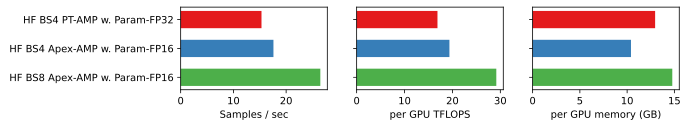

In [24]:
# Compare AMP backend
compare([bert_4_pt_amp, bert_4_apex_amp, bert_8_apex_amp], "amp.pdf" if dump_fig_to_pdf else None)

## BERT on a Single GPU with Megatron-LM

Though `HuggingFace` is the most popular package for transformers, it's not the fastest one. Here let's use Megatron-LM from Nvidia. First download vocab and a sample dataset. 

In [12]:
!wget -nc https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/bert-sample_text_sentence.bin
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/bert-sample_text_sentence.idx
    
clear_output()

Define the function to run BERT and parse its log.

In [7]:
def megatron_bert(exp):    
    cmd = f'''{exp.launcher} Megatron-LM/pretrain_bert.py \
--num-layers {exp.num_layers} --hidden-size {exp.hidden_size} \
--num-attention-heads {exp.num_heads} \
--tensor-model-parallel-size {exp.tensor_para} \
--micro-batch-size {exp.batch_size} \
--seq-length {exp.seq_len} --max-position-embeddings {exp.seq_len} \
--train-iters {exp.steps} \
--data-path bert-sample_text_sentence \
--vocab-file bert-large-uncased-vocab.txt \
--data-impl mmap --lr 0.00015 --log-interval 5'''
    if exp.bf16: cmd += ' --bf16'
    if exp.fp16: cmd += ' --fp16'
        
    if exp.kwargs is not None and "flags" in exp.kwargs:
        cmd += " " + " ".join(exp.kwargs["flags"])

    cmd += ' > log.txt 2>&1'
    print(f"Running command {cmd}", flush=True)
    os.system(cmd)
    return megatron_log(exp, 'log.txt') 
    
def megatron_log(exp, log_filename):
    with open(log_filename) as f:
        text = f.read()
    # Find the last number after the key, returns 0 if not exists
    def query(key, last_only=True):
        values = re.findall(key+': +([\d\.]+)', text)
        if not values:
            return None
        if last_only:
            return float(values[-1])
        return [float(v) for v in values]
    if 'CUDA out of memory' in text:
        print('Out of GPU memory, try a smaller batch size')
        return
    
    iter_times = query('elapsed time per iteration \(ms\)', last_only=False) 
    if not iter_times:
        print(f'Failed. Check "{log_filename}" to find error')
        return
    
    # 1. Every 5 steps, Megatron reports the average iteration time of the past 5 steps.
    # 2. We remove the first value (of the first 5 steps) as the warmup.
    iter_time = (sum(iter_times[1:]) * 5) / (exp.steps - 5) / 1e3
    total_time = iter_time * exp.steps
    exp.samples_per_sec = query('consumed samples') / total_time

    exp.gpu_mem = query('max allocated')/1e3
    print('Time breakdown\t\t: forward+backward %.2f, communication %.2f, optimizer %.2f' %(
        (query('forward-compute')+query('backward-compute')) / iter_time, 
        query('backward-params-all-reduce') / iter_time, query('optimizer') / iter_time))        
    return exp

In [18]:
bert_4_apex_amp = hf_bert(Exp(
    'HF BS4 Apex-AMP w. Param-FP16', 'bert-large-uncased', 4, fp16=True, optim='adamw_apex_fused',
    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0;     export PYTHONPATH=/home/ubuntu/workspace_hf/model-schedule:$PYTHONPATH; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 4 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1


In [19]:
mega_bert_4_no_fuse = megatron_bert(Exp('Megatron BS8 AMP w. Param-FP16 NoFusion', 'bert-large-uncased', 4, fp16=True,
    kwargs={"flags": ["--no-bias-gelu-fusion", "--no-bias-dropout-fusion",
                      "--no-persist-layer-norm", "--no-masked-softmax-fusion"]}))

Running command torchrun --nproc_per_node 1 Megatron-LM/pretrain_bert.py --num-layers 24 --hidden-size 1024 --num-attention-heads 16 --tensor-model-parallel-size 1 --micro-batch-size 4 --seq-length 512 --max-position-embeddings 512 --train-iters 20 --data-path bert-sample_text_sentence --vocab-file bert-large-uncased-vocab.txt --data-impl mmap --lr 0.00015 --log-interval 5 --fp16 --no-bias-gelu-fusion --no-bias-dropout-fusion --no-persist-layer-norm --no-masked-softmax-fusion > log.txt 2>&1
Time breakdown		: forward+backward 862.40, communication 10.32, optimizer 139.86


In [24]:
bert_4_apex_amp_o3 = hf_bert(Exp(
    'HF BS4 Apex-AMP-O3 w. Param-FP16', 'bert-large-uncased', 4, fp16=True, optim='adamw_apex_fused',
    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O3"]}))

Running command export CUDA_VISIBLE_DEVICES=0;     export PYTHONPATH=/home/ubuntu/workspace_hf/model-schedule:$PYTHONPATH; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 4 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O3 > log.txt 2>&1


Samples / sec: ['18.32', '16.64', '23.99']
per GPU TFLOPS: ['20.17', '18.32', '26.41']
per GPU memory (GB): ['10.41', '8.53', '7.30']


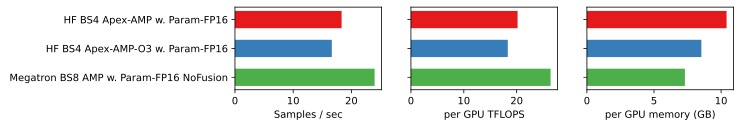

In [23]:
compare([bert_4_apex_amp, bert_4_apex_amp_o3, mega_bert_4_no_fuse], None)

In [14]:
# BS=12 OOM
mega_bert_8 = megatron_bert(Exp('Megatron BS8 AMP w. Param-FP16', 'bert-large-uncased', 8, fp16=True))

Running command torchrun --nproc_per_node 1 Megatron-LM/pretrain_bert.py --num-layers 24 --hidden-size 1024 --num-attention-heads 16 --tensor-model-parallel-size 1 --micro-batch-size 8 --seq-length 512 --max-position-embeddings 512 --train-iters 20 --data-path bert-sample_text_sentence --vocab-file bert-large-uncased-vocab.txt --data-impl mmap --lr 0.00015 --log-interval 5 --fp16 > log.txt 2>&1
Time breakdown		: forward+backward 888.59, communication 8.10, optimizer 133.71


Samples / sec: ['25.59', '37.88']
per GPU TFLOPS: ['28.18', '41.71']
per GPU memory (GB): ['14.78', '10.50']


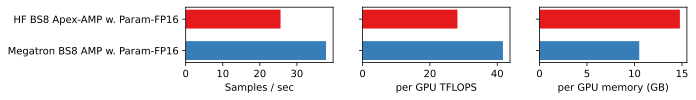

In [15]:
# Compare HF and Megatron
compare([bert_8_apex_amp, mega_bert_8], "hf_mega.pdf" if dump_fig_to_pdf else None)

In [17]:
mega_bert_8_no_fuse = megatron_bert(Exp('Megatron BS8 AMP w. Param-FP16 NoFusion', 'bert-large-uncased', 8, fp16=True,
    kwargs={"flags": ["--no-bias-gelu-fusion", "--no-bias-dropout-fusion",
                      "--no-persist-layer-norm", "--no-masked-softmax-fusion"]}))

Running command torchrun --nproc_per_node 1 Megatron-LM/pretrain_bert.py --num-layers 24 --hidden-size 1024 --num-attention-heads 16 --tensor-model-parallel-size 1 --micro-batch-size 4 --seq-length 512 --max-position-embeddings 512 --train-iters 20 --data-path bert-sample_text_sentence --vocab-file bert-large-uncased-vocab.txt --data-impl mmap --lr 0.00015 --log-interval 5 --fp16 --no-bias-gelu-fusion --no-bias-dropout-fusion --no-persist-layer-norm --no-masked-softmax-fusion > log.txt 2>&1
Time breakdown		: forward+backward 862.05, communication 10.29, optimizer 140.48


AttributeError: 'NoneType' object has no attribute 'samples_per_sec'

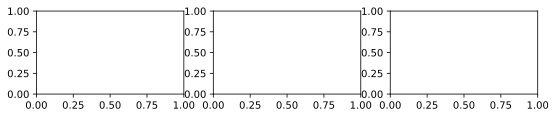

In [17]:
# Compare HF and Megatron with and without fused kernels
compare([bert_8_apex_amp, mega_bert_8_no_fuse, mega_bert_8], "hf_mega_fused.pdf" if dump_fig_to_pdf else None)

In [ ]:
flags = ["--no-bias-gelu-fusion",
         "--no-bias-dropout-fusion",
         "--no-persist-layer-norm",
         "--no-masked-softmax-fusion"]
mega_bert_8_no_fuse_ablation = [
    megatron_bert(Exp("no-fusion", 'bert-large-uncased', 8, fp16=True, kwargs={"flags": flags}))
]
while flags:
    curr_flag, flags = flags[0], flags[1:]
    ret = megatron_bert(Exp(curr_flag.replace("--no-", "+"), 'bert-large-uncased', 8, fp16=True,
                            kwargs={"flags": flags}))
    mega_bert_8_no_fuse_ablation.append(ret)

In [ ]:
# Ablation study of fusion kernels
compare(mega_bert_8_no_fuse_ablation, "fuse_ablation.pdf" if dump_fig_to_pdf else None)